DIGINETICA

https://competitions.codalab.org/competitions/11161#learn_the_details-evaluation

In [1]:
import pandas as pd
import numpy as np
import util

In [2]:
q = pd.read_csv('./data/diginetica/dataset-train-diginetica/train-queries.csv', sep=';')
v = pd.read_csv('./data/diginetica/dataset-train-diginetica/train-item-views.csv', sep=';')
c = pd.read_csv('./data/diginetica/dataset-train-diginetica/train-clicks.csv', sep=';')
p = pd.read_csv('./data/diginetica/dataset-train-diginetica/train-purchases.csv', sep=';')
products = pd.read_csv('./data/diginetica/dataset-train-diginetica/products.csv', sep=';')
product_cat = pd.read_csv('./data/diginetica/dataset-train-diginetica/product-categories.csv', sep=';')

/home/yua4/pareto/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(f'q:           {list(q.columns)}')
print(f'v:           {list(v.columns)}')
print(f'c:           {list(c.columns)}')
print(f'p:           {list(p.columns)}')
print(f'products:    {list(products.columns)}')
print(f'product_cat: {list(product_cat.columns)}')


q:           ['queryId', 'sessionId', 'userId', 'timeframe', 'duration', 'eventdate', 'searchstring.tokens', 'categoryId', 'items', 'is.test']
v:           ['sessionId', 'userId', 'itemId', 'timeframe', 'eventdate']
c:           ['queryId', 'timeframe', 'itemId']
p:           ['sessionId', 'userId', 'timeframe', 'eventdate', 'ordernumber', 'itemId']
products:    ['itemId', 'pricelog2', 'product.name.tokens']
product_cat: ['itemId', 'categoryId']


In [9]:
q.shape

(923127, 10)

In [4]:
qq = q.iloc[:10_000].copy()

In [5]:
# query items
qi = []
for _, row in qq.iterrows():
    qi += [[row['userId'], row['sessionId'], row['queryId'], i, int(item)] for i, item in enumerate(row['items'].split(','))]
qi = pd.DataFrame(qi, columns=['userId', 'sessionId', 'queryId', 'position', 'itemId'])
# clicks
qi = pd.merge(qi, c, how='left', on=['queryId', 'itemId'])
qi = qi.rename(columns={'timeframe': 'clicked'})
qi.loc[pd.notna(qi['clicked']), 'clicked'] = 1
qi.loc[pd.isna(qi['clicked']), 'clicked'] = 0
# purchases
qi = pd.merge(qi, p[['userId', 'sessionId', 'itemId', 'timeframe']], how='left', on=['userId', 'sessionId', 'itemId'])
qi = qi.rename(columns={'timeframe': 'purchased'})
qi.loc[pd.notna(qi['purchased']), 'purchased'] = 1
qi.loc[pd.isna(qi['purchased']), 'purchased'] = 0
# product prices
qi = pd.merge(qi, products[['itemId', 'pricelog2']], how='left', on=['itemId'])
qi = qi.rename(columns={'pricelog2': 'price'})
# totals
totals = qi.groupby('queryId')[['clicked', 'purchased']].sum().reset_index().rename(columns={'clicked':'clicked_total', 'purchased':'purchased_total', })
qi = qi.merge(totals, on='queryId')

In [6]:
# 6.2.2
no_clicks = qi['clicked_total'] == 0
no_purchases = qi['purchased_total'] == 0
qi_groupby_cumsum = qi.groupby('queryId').cumsum()
metrics = pd.DataFrame()

qi.loc[no_clicks, 'c_map'] = 0
qi.loc[no_clicks, 'c_ndcg'] = 0
qi.loc[~no_clicks, 'cum_clicks'] = qi.groupby('queryId')['clicked'].cumsum()
qi.loc[~no_clicks, 'c_ap'] = (qi['cum_clicks'] / (qi['position'] + 1))
qi.loc[~no_clicks, 'c_ap_cumsum'] = (1 / (qi['position'] + 1)) * qi.groupby('queryId')['c_ap'].cumsum()
qi.loc[(~no_clicks) & (qi['clicked'] == 0), 'c_ap_cumsum'] = 0
# qi.loc[~no_clicks, 'c_map'] = qi.groupby('queryId')['c_ap_cumsum'].cumsum()
metrics['c_map'] = qi.groupby('position')['c_ap_cumsum'].sum() / len(qi[~no_clicks].groupby('queryId'))

qi.loc[~no_clicks, 'c_dcg'] = (np.power(2, qi['cum_clicks']) - 1) / np.log2((qi['position'] + 1) + 1)
qi.loc[~no_clicks, 'c_dcg_cumsum'] = qi.groupby('queryId')['c_dcg'].cumsum()
qi.loc[~no_clicks, 'c_idcg'] = (np.power(2, (qi['position'] + 1)) - 1) / np.log2((qi['position'] + 1) + 1)
qi.loc[~no_clicks, 'c_idcg_cumsum'] = qi.groupby('queryId')['c_idcg'].cumsum()
qi.loc[~no_clicks, 'c_ndcg'] = qi['c_dcg_cumsum'] / qi['c_idcg_cumsum']
metrics['c_ndcg'] = qi.groupby('position')['c_ndcg'].sum() / len(qi[~no_clicks].groupby('queryId'))

# qi = qi.drop(columns=['c_ap', 'c_dcg', 'c_idcg', 'c_ap_cumsum', 'cum_clicks', 'c_dcg_cumsum', 'c_idcg_cumsum'])

qi.loc[no_purchases, 'g_map'] = 0
qi.loc[no_purchases, 'g_ndcg'] = 0
qi.loc[~no_purchases, 'cum_purchases'] = qi.groupby('queryId')['purchased'].cumsum()
qi.loc[~no_purchases, 'g_ap'] = (qi['cum_purchases'] / (qi['position'] + 1))
qi.loc[~no_purchases, 'g_ap_cumsum'] = (1 / (qi['position'] + 1)) * qi.groupby('queryId')['g_ap'].cumsum()
qi.loc[(~no_purchases) & (qi['purchased'] == 0), 'g_ap_cumsum'] = 0
# qi.loc[~no_purchases, 'g_map'] = qi.groupby('queryId')['g_ap_cumsum'].cumsum()
metrics['g_map'] = qi.groupby('position')['g_ap_cumsum'].sum() / len(qi[~no_purchases].groupby('queryId'))

qi.loc[~no_purchases, 'g_dcg'] = qi['price'] * (np.power(2, qi['cum_purchases']) - 1) / np.log2((qi['position'] + 1) + 1)
qi.loc[~no_purchases, 'g_dcg_cumsum'] = qi.groupby('queryId')['g_dcg'].cumsum()
qi.loc[~no_purchases, 'g_idcg'] = qi['price'] * (np.power(2, (qi['position'] + 1)) - 1) / np.log2((qi['position'] + 1) + 1)
qi.loc[~no_purchases, 'g_idcg_cumsum'] = qi.groupby('queryId')['g_idcg'].cumsum()
qi.loc[(~no_purchases) & (qi['price'] == 0), 'g_ndcg'] = 0
qi.loc[(~no_purchases) & (qi['price'] > 0), 'g_ndcg'] = qi['g_dcg'] / qi['g_idcg']
metrics['g_ndcg'] = qi.groupby('position')['g_ndcg'].sum() / len(qi[~no_purchases].groupby('queryId'))

# qi = qi.drop(columns=['g_ap', 'g_dcg', 'g_idcg', 'g_ap_cumsum', 'cum_purchases', 'g_dcg_cumsum', 'g_idcg_cumsum'])

# qi = qi.drop(columns=['userId', 'sessionId', 'clicked_total', 'purchased_total'])

In [7]:
metrics

,c_map,c_ndcg,g_map,g_ndcg
position,,,,
0,0.050139,0.049211,0.065217,6.521739e-02
1,0.013734,0.039309,0.010870,3.260870e-02
2,0.007015,0.030631,0.003623,1.863354e-02
3,0.003962,0.022665,0.004076,1.304348e-02
4,0.002848,0.016192,0.003043,7.713885e-03
5,0.001690,0.011083,0.003019,5.866115e-03
6,0.001431,0.007363,0.000665,3.166724e-03
7,0.001506,0.004828,0.000510,1.662404e-03
8,0.001103,0.003034,0.000671,9.572024e-04


In [24]:
# 5
pi = pd.DataFrame()
pi['n'] = qi.groupby('itemId').size()
pi[['clicked', 'purchased', 'price']] = qi.groupby('itemId')[['clicked', 'purchased', 'price']].mean()

pi.loc[pi['clicked'] > 0, 'l_ctr'] = -np.log(pi['clicked'] / pi['n'])
pi.loc[pi['clicked'] == 0, 'l_ctr'] = 0
l_ctr = (1 / len(pi)) * pi['l_ctr'].sum()

pi.loc[pi['purchased'] > 0, 'l_gmv'] = -pi['price'] * np.log(pi['purchased'] / pi['n'])
# pi.loc[pi['purchased'] > 0, 'l_gmv'] = pi['price'] * np.log(pi['purchased'] / pi['n']) + np.log(pi['purchased'] / pi['clicked'])
pi.loc[pi['purchased'] == 0, 'l_gmv'] = 0
l_gmv = (1 / len(pi)) * pi['l_gmv'].sum()

pi = pi.reset_index()
l_ctr, l_gmv

/home/yua4/pareto/venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yua4/pareto/venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-0.6744283718288002, -0.16114042309066468)

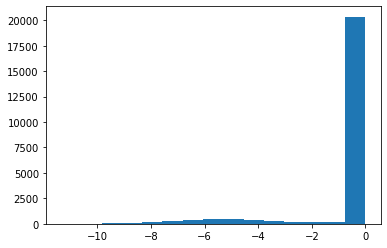

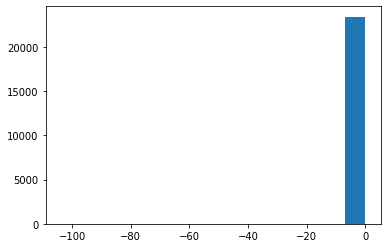

In [43]:
import matplotlib.pyplot as plt
plt.hist(pi[pi['l_ctr'].notna()]['l_ctr'], bins=15)
plt.show()
plt.hist(pi[pi['l_gmv'].notna()]['l_gmv'], bins=15)
plt.show()

In [40]:
pi.iloc[pi['l_gmv'].idxmin()]

itemId       39388.000000
n              320.000000
clicked          0.037500
purchased        0.003125
price            9.000000
l_ctr           -9.051735
l_gmv         -103.829778
Name: 9875, dtype: float64

In [41]:
pi.describe()

,itemId,n,clicked,purchased,price,l_ctr,l_gmv
count,23504.000000,23504.000000,23504.000000,23504.000000,23504.000000,23504.000000,23504.000000
mean,91027.714900,8.141167,0.031482,0.000441,6.713283,-0.674428,-0.161140
std,98724.243538,21.789970,0.125927,0.014692,2.941984,1.861861,3.161471
min,2.000000,1.000000,0.000000,0.000000,0.000000,-11.358585,-103.829778
25%,21330.750000,1.000000,0.000000,0.000000,6.000000,0.000000,0.000000
50%,57234.000000,2.000000,0.000000,0.000000,8.000000,0.000000,0.000000
75%,131425.250000,7.000000,0.000000,0.000000,8.000000,0.000000,0.000000
max,581918.000000,615.000000,1.000000,1.000000,13.000000,0.000000,0.000000
